In [65]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [66]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pydicom import read_file
import scanpy as sc
import copy
import sys
import glob
from copy import deepcopy
from scipy import stats
from matplotlib.gridspec import GridSpec
import tqdm 
import seaborn as sns
%matplotlib inline

PROJ_DIR = "/home/icb/olle.holmberg/projects/LODE"

sys.path.insert(0, os.path.join(PROJ_DIR, 'feature_segmentation/utils'))

import plotting
plt.style.use('seaborn')

WORK_SPACE = "/storage/groups/ml01/workspace/olle.holmberg/LODE/feature_segmentation"
DATA_DIR = "/storage/groups/ml01/datasets/raw/2018_LMUAugenklinik_niklas.koehler"

SEG_E2_PATH = os.path.join(WORK_SPACE, "segmentation/lmu_data/segmented_volumes20201026")


oct_meta_pd = pd.read_csv(os.path.join(DATA_DIR, "joint_export/oct_meta_information.csv"))

# remove non standard format paths
oct_meta_pd = oct_meta_pd[~oct_meta_pd.oct_path.str.contains("Non Standard Format")]

data_pd = pd.read_csv(os.path.join(DATA_DIR, "sequence_data/longitudinal_properties_naive.csv"))

#### add patient id and lateraliy
data_pd["patient_id"] = data_pd.sequence.str.split("_", expand=True)[0]
data_pd["laterality"] = data_pd.sequence.str.split("_", expand=True)[1]

# add seg numpy a
data_pd["seg_record_1"] = data_pd.sequence + "_" + data_pd.study_date_1.str.replace("-", "") + ".npy"
data_pd["seg_record_3"] = data_pd.sequence + "_" + data_pd.study_date_3.str.replace("-", "") + ".npy"
data_pd["seg_record_12"] = data_pd.sequence + "_" + data_pd.study_date_12.str.replace("-", "") + ".npy"


# rename atrophy and thickness columns
for column in data_pd.columns:
    if "atropy_percentage" in column:
        data_pd.rename(columns={column: column.replace("atropy_percentage", "atropypercentage")}, inplace=True)
        
    if "thickness_mean" in column:
        data_pd.rename(columns={column: column.replace("thickness_mean", "thicknessmean")}, inplace=True)

## join study date one DICOM file

In [67]:
study_date_1_dc = data_pd.sequence.str.split("_", expand=True)
study_date_1_dc = study_date_1_dc.rename(columns={0:"PATNR",1:"laterality"})
study_date_1_dc["study_date"] = data_pd["study_date_1"].str.replace("-", "")

study_date_1_dc.PATNR = study_date_1_dc.PATNR.astype(np.int64)
study_date_1_dc.study_date = study_date_1_dc.study_date.astype(np.int64)

keys = ["PATNR", "laterality", "study_date"]
result1 = pd.merge(study_date_1_dc, oct_meta_pd[keys + ["oct_path"]], left_on=keys, right_on=keys, how="left")
result1 = result1.drop_duplicates(subset=keys)
result1 = result1.rename(columns={"oct_path": "study_date_1_dicom_path"})

result1["sequence"] = result1.PATNR.astype(str) + "_" + result1.laterality
##############

study_date_3_dc = data_pd.sequence.str.split("_", expand=True)
study_date_3_dc = study_date_3_dc.rename(columns={0:"PATNR",1:"laterality"})
study_date_3_dc["study_date"] = data_pd["study_date_3"].str.replace("-", "")

study_date_3_dc.PATNR = study_date_3_dc.PATNR.astype(np.int64)
study_date_3_dc.study_date = study_date_3_dc.study_date.astype(np.int64)

keys = ["PATNR", "laterality", "study_date"]
result3 = pd.merge(study_date_3_dc, oct_meta_pd[keys + ["oct_path"]], left_on=keys, right_on=keys, how="left")
result3 = result3.drop_duplicates(subset=keys)
result3 = result3.rename(columns={"oct_path": "study_date_3_dicom_path"})

result3["sequence"] = result3.PATNR.astype(str) + "_" + result3.laterality
#############

study_date_12_dc = data_pd.sequence.str.split("_", expand=True)
study_date_12_dc = study_date_12_dc.rename(columns={0:"PATNR",1:"laterality"})
study_date_12_dc["study_date"] = data_pd["study_date_12"].str.replace("-", "")

study_date_12_dc.PATNR = study_date_12_dc.PATNR.astype(np.int64)
study_date_12_dc.study_date = study_date_12_dc.study_date.astype(np.int64)

keys = ["PATNR", "laterality", "study_date"]
result12 = pd.merge(study_date_12_dc, oct_meta_pd[keys + ["oct_path"]], left_on=keys, right_on=keys, how="left")
result12 = result12.drop_duplicates(subset=keys)
result12 = result12.rename(columns={"oct_path": "study_date_12_dicom_path"})

result12["sequence"] = result12.PATNR.astype(str) + "_" + result12.laterality

data_pd = pd.merge(data_pd, result1[["study_date_1_dicom_path", "sequence"]], left_on="sequence", right_on="sequence", 
         how = "left")

data_pd = pd.merge(data_pd, result3[["study_date_3_dicom_path", "sequence"]], left_on="sequence", right_on="sequence", 
         how = "left")

data_pd = pd.merge(data_pd, result12[["study_date_12_dicom_path", "sequence"]], left_on="sequence", right_on="sequence", 
         how = "left")

## check so all records has dicom and seg paths

In [68]:
columns_to_check = ["seg_record_1", 
                    "seg_record_3", 
                    "seg_record_12", 
                    "study_date_1_dicom_path", 
                    "study_date_3_dicom_path", 
                    "study_date_12_dicom_path"]

for col in columns_to_check:
    print("Number of unassigned records are: ",col, sum(data_pd[col].isna()))

Number of unassigned records are:  seg_record_1 0
Number of unassigned records are:  seg_record_3 0
Number of unassigned records are:  seg_record_12 0
Number of unassigned records are:  study_date_1_dicom_path 0
Number of unassigned records are:  study_date_3_dicom_path 0
Number of unassigned records are:  study_date_12_dicom_path 0


In [69]:
# Define function to output plot of the model coefficients

def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    #coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    # sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=22, 
                 ecolor='steelblue',capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=22)
    
    # Coefficients
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    return plt.show()

#### How many sequence are treated?

In [70]:
print(f"number of treated sequences {data_pd.shape[0]}")

number of treated sequences 574


#### Insertion type distribution

Text(0.5, 1.0, 'month 24')

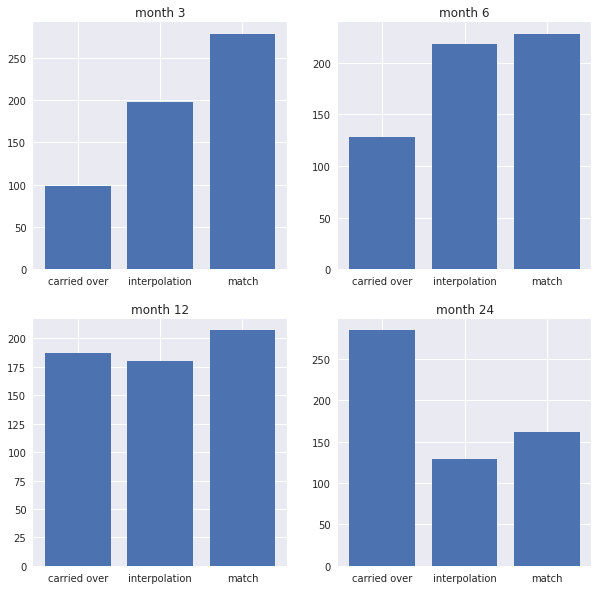

In [71]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

month_3 = data_pd.groupby(['insertion_type_3']).size().tolist()
month_6 = data_pd.groupby(['insertion_type_6']).size().tolist()
month_12 = data_pd.groupby(['insertion_type_12']).size().tolist()
month_24 = data_pd.groupby(['insertion_type_24']).size().tolist()

x_labels = ["carried over", "interpolation", "match"]

ax1.bar(x_labels, month_3,align='center')
ax1.set_title("month 3")
ax2.bar(x_labels,month_6,align='center')
ax2.set_title("month 6")
ax3.bar(x_labels,month_12,align='center')
ax3.set_title("month 12")
ax4.bar(x_labels,month_24,align='center')
ax4.set_title("month 24")

## Filter data based on time series eclusion criterias

In [72]:
columns = ["time_range_3", "time_range_before_3", "time_range_after_3", "insertion_type_3",
            "time_range_6", "time_range_before_6", "time_range_after_6", "insertion_type_6", 
           "time_range_12", "time_range_before_12", "time_range_after_12", "insertion_type_12"]

filter_base = data_pd[columns]

# filter for fist month where VA values are available
filter_1 = ~data_pd.cur_va_rounded_1.isna()

# 3 month bools
interp_3 = filter_base.insertion_type_3 == "interpolation" 
carry_over_3 = filter_base.insertion_type_3 == "carry_over" 
match_3 = filter_base.insertion_type_3 == "match" 

# 6 month bools
interp_6 = filter_base.insertion_type_6 == "interpolation" 
carry_over_6 = filter_base.insertion_type_6 == "carry_over" 
match_6 = filter_base.insertion_type_6 == "match" 

# 12 month bools
interp_12 = filter_base.insertion_type_12 == "interpolation" 
carry_over_12 = filter_base.insertion_type_12 == "carry_over" 
match_12 = filter_base.insertion_type_12 == "match"

DAY_FILTER = 60

# interpolation time filters
interp_time_before_3 = filter_base.time_range_before_3 < DAY_FILTER
interp_time_after_3 = filter_base.time_range_after_3 < DAY_FILTER

interp_time_before_6 = filter_base.time_range_before_6 < DAY_FILTER
interp_time_after_6 = filter_base.time_range_after_6 < DAY_FILTER

interp_time_before_12 = filter_base.time_range_before_12 < DAY_FILTER
interp_time_after_12 = filter_base.time_range_after_12 < DAY_FILTER

# carry over time filters
carry_over_time_after_3 = filter_base.time_range_3 < DAY_FILTER
carry_over_time_after_6 = filter_base.time_range_6 < DAY_FILTER
carry_over_time_after_12 = filter_base.time_range_12 < DAY_FILTER

In [73]:
# interpolation 3 months
interp_bef = np.logical_and(interp_3.values, interp_time_before_3)
interp_aft = np.logical_and(interp_3.values, interp_time_after_3)

interp_3 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_3 = np.logical_and(carry_over_3.values, carry_over_time_after_3)

insertion_3_ = np.logical_or(carry_over_3, interp_3)
filter_3 = np.logical_or(insertion_3_, match_3)

print("Number of filtered sequences for 3 months are:", sum(filter_3))


# interpolation 6 months
interp_bef = np.logical_and(interp_6.values, interp_time_before_6)
interp_aft = np.logical_and(interp_6.values, interp_time_after_6)

interp_6 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_6 = np.logical_and(carry_over_6.values, carry_over_time_after_6)

insertion_6_ = np.logical_or(carry_over_6, interp_6)
filter_6 = np.logical_or(insertion_6_, match_6)

print("Number of filtered sequences for 6 months are:", sum(filter_6))


# interpolation 12 months
interp_bef = np.logical_and(interp_12.values, interp_time_before_12)
interp_aft = np.logical_and(interp_12.values, interp_time_after_12)

interp_12 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_12 = np.logical_and(carry_over_12.values, carry_over_time_after_12)

insertion_12_ = np.logical_or(carry_over_12, interp_12)
filter_12 = np.logical_or(insertion_12_, match_12)

print("Number of filtered sequences for 12 months are:", sum(filter_12))

Number of filtered sequences for 3 months are: 346
Number of filtered sequences for 6 months are: 332
Number of filtered sequences for 12 months are: 278


## Filter statistics

In [74]:
print("", np.sum(filter_1))
print("", np.sum(filter_1&filter_3&filter_6&filter_12))
print("", np.sum(filter_1&filter_6&filter_12))
print("", np.sum(filter_1&filter_12))
print("", np.sum(filter_1&filter_6))
print("", np.sum(filter_1&filter_3))
print("", np.sum(filter_1&filter_3&filter_6))
print("", np.sum(filter_1&filter_3&filter_12))

 574
 180
 216
 278
 332
 346
 280
 206


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

PIXEL_TO_VOLUME = 0.010661*0.003872*0.112878

In [76]:
def sum_etdrs(table, time):
    label_mapping = {f"_1_{time}":f"epm_{time}", f"_3_{time}":f"irf_{time}", f"_4_{time}":f"srf_{time}", 
                     f"_5_{time}":f"srhm_{time}", f"_6_{time}":f"rpe_{time}", f"_7_{time}":f"fvpde_{time}", 
                     f"_8_{time}":f"drusen_{time}", f"_9_{time}":f"phm_{time}", f"_10_{time}":f"choroid_{time}", 
                     f"_13_{time}":f"fibrosis_{time}"}
    
    feature_names = [f"_1_{time}", f"_3_{time}", 
                     f"_4_{time}", f"_5_{time}", 
                     f"_6_{time}", f"_7_{time}", 
                     f"_8_{time}", f"_9_{time}", 
                     f"_10_{time}", f"_13_{time}"]


    table_non_spatial_pd = pd.DataFrame([])

    for feature in feature_names:
        col_to_sum = table.columns.str.endswith(feature)
        table_non_spatial_pd[feature] = table.iloc[:,col_to_sum].sum(1)

    table_non_spatial_pd = table_non_spatial_pd.rename(columns=label_mapping)
    return table_non_spatial_pd*PIXEL_TO_VOLUME

def get_feature_dicts(times, table):
    feature_dict = {}
    for time in times:
            feature_dict[f"feature_{time}"] = sum_etdrs(table, time=time)
    
    delta_feature_dict = {}
    
    # calculate delta columns
    for k, time in enumerate(times):
        if k < len(times) - 1:
            remaining_tps = times[k + 1:]
            for next_time_point in remaining_tps:
                delta_columns = []
                for col in feature_dict[f"feature_{time}"].columns:
                    feat, t = col.split("_")
                    delta_columns.append(f"{feat}_{next_time_point}_delta_{t}")
                    
                delta_pd = pd.DataFrame(np.array(feature_dict[f"feature_{next_time_point}"]) - 
                                        np.array(feature_dict[f"feature_{time}"]),
                                       columns=delta_columns)

                delta_feature_dict[f"feature_{next_time_point}_{time}"] = delta_pd
    return {**delta_feature_dict, **feature_dict}

def get_va_dict(times, table):
    column_starter = "cur_va_rounded_"
    va_dict = {}
    delta_va_dict = {}
    
    for time in times:
        va_dict[f"va_{time}"] = table[f"cur_va_rounded_{time}"]
        
    # calculate delta columns
    for k, time in enumerate(times):
        if k < len(times) - 1:
            remaining_tps = times[k + 1:]
            for next_time_point in remaining_tps:
                delta_columns = [f"va_{next_time_point}_delta_{time}"]
                
                delta_pd = pd.DataFrame(np.array(va_dict[f"va_{next_time_point}"]) - np.array(va_dict[f"va_{time}"]),
                                       columns=delta_columns)
                delta_va_dict[f"va_{next_time_point}_{time}"] = delta_pd
    
    return {**delta_va_dict, **va_dict}


time_filters = {1: filter_1, 3: filter_3, 6: filter_6, 12: filter_12}

def associate_time_n_factors(table=None, spatial_sum=False, times=[1, 12]):
    # filter time points
    for tp in times:
        table = table[time_filters[tp]]
    
    seq_columns = ['patient_id', 'laterality']
    table["seq"] = table[seq_columns[0]] + "_" + table[seq_columns[1]]
    
    # sum etdrs features for seg features across the time points    
    features_data_dict = get_feature_dicts(times, table)
    va_data_dict = get_va_dict(times, table)
    
    data_dict = {**va_data_dict, **features_data_dict} 
    data_frames = list(data_dict.keys())

    df = data_dict[data_frames[0]]
    for data_frame in data_frames[1:]:
        df = pd.concat([df.reset_index(drop=True), data_dict[data_frame].reset_index(drop=True)], axis=1)
    
    for time in times[1:]:
        df[f"n_injections_{time}"] = table[f"cumsum_injections_{time}"].values.tolist()
    
    
    for time in times[1:]:
        df[f"cataract_surgery_{time}"] = table[f"cataract_surgery_{time}"].values.tolist()
        
    df[f"cataract_surgery_1"] = table["cataract_surgery_before_sequence"]
    # filter all columns for the independent ones in list
    df.index = table["seq"]
    return df

In [77]:
def assert_times(time_point_list):
    allowed_values = [1, 3, 6, 12]
    
    for value in time_point_list:
        if value not in allowed_values:
            return False
        else:
            continue
    return True

# features dependents
def get_seg_dependents_str(seg_features, seg_delta, seg_times):
    seg_dependents = []

    for seg_feature in seg_features:
        for time in seg_times:
            seg_dependents.append(f"{seg_feature}_{time}") 
    
        if seg_delta:
            # add all delta columns
            for k, s_time in enumerate(seg_times[:-1]):

                remaining_times = deepcopy(seg_times)
                remaining_times.remove(s_time)

                for r_time in remaining_times[k:]:
                    if f"{r_time}-{s_time}" in seg_delta:
                        seg_dependents.append(f"{seg_feature}_{r_time}_delta_{s_time}")

    return seg_dependents

def get_va_dependents_str(va_delta, va_times):
    va_dependents = []

    for va_time in va_times:
        va_dependents.append(f"cur_va_rounded_{va_time}")
    
    if va_delta:
        # add all delta columns
        for k, s_time in enumerate(va_times[:-1]):

            remaining_times = deepcopy(va_times)
            remaining_times.remove(s_time)

            for r_time in remaining_times[k:]:
                if f"{r_time}-{s_time}" in va_delta:
                    va_dependents.append(f"va_{r_time}_delta_{s_time}")
                else:
                    continue
    return va_dependents

### Factors associated with baseline VA

In [79]:
'''
Available features: epm, irf, srf, srhm, rpe, fv_pde, drusen, phm, choroid, fibrosis
'''
from copy import deepcopy

'''
exmaples feature setting: 

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["3-1", "6-3"]
seg_times = [1, 3, 6, 12]

va_delta = ["3-1", "6-3"]
va_times = [1, 3, 6]

injection_times = [3, 6]
'''

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = []
seg_times = [1]

assert assert_times(seg_times), "Selected time points contains not allowed values"

seg_independents = get_seg_dependents_str(seg_features, seg_delta, seg_times)

va_delta = []
va_times = []

assert assert_times(va_times), "Selected time points contains not allowed values"

va_independents = get_va_dependents_str(va_delta, va_times)

injection_times = []

assert assert_times(injection_times), "Selected time points contains not allowed values"

injection_independents = []
for it in injection_times:
    injection_dependents.append(f"n_injections_{it}")

abt = associate_time_n_factors(table=data_pd, spatial_sum=True, times=[1, 3, 12])

independent_variables = injection_independents + seg_independents + va_independents + ["cataract_surgery_1"]

# filter out operated while treated
abt_f = abt[~abt.cataract_surgery_12.fillna(0).astype(bool)]

abt_f.cataract_surgery_1 = abt_f.cataract_surgery_1.fillna(0).astype(bool)

# set independent vars
df_regression = abt_f[independent_variables]

# set dependent var
df_regression["y"] = abt["cur_va_rounded_1"]

df_regression = pd.concat((df_regression,
                  pd.get_dummies(df_regression['cataract_surgery_1'], drop_first=True)), axis=1)

df_regression.loc[:, "cat_true"] = pd.get_dummies(df_regression['cataract_surgery_1'])[True] 

# remove cataract surgery as feature
independent_variables.pop()

'cataract_surgery_1'

#### fit model

In [80]:
indep_vars = independent_variables  + ["cat_true"]#, "cat_false"]
model_lin = sm.OLS.from_formula(f"y ~ {' + '.join(indep_vars)}", 
                                data=df_regression)

result_lin = model_lin.fit()
regression_summary = result_lin.summary()
reg_table = pd.read_html(result_lin.summary().tables[1].as_html(),header=0,index_col=0)[0]

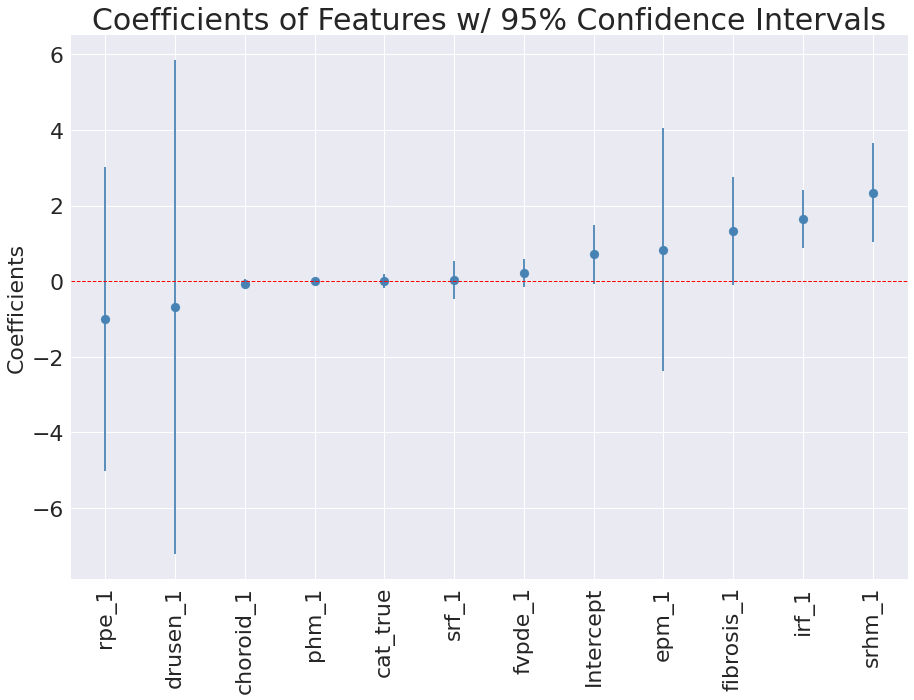

In [81]:
# Plot coefficients w/95% confidence intervals for Model
coefplot(result_lin)

In [82]:
from statsmodels.tools.eval_measures import meanabs

X = df_regression[indep_vars]
y = df_regression["y"]

# now generate predictions
ypred = result_lin.predict(X)

# calc rmse
mae = meanabs(y, ypred)
mae_mean_predictor = meanabs(y, [y.mean()]*y.shape[0])

print("model mae is: ", mae, "mean predictor mae is: ", mae_mean_predictor)

model mae is:  0.28309635196790495 mean predictor mae is:  0.36329281442995787


In [83]:
regression_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     8.466
Date:                Tue, 01 Jun 2021   Prob (F-statistic):           2.29e-11
Time:                        13:51:41   Log-Likelihood:                -97.009
No. Observations:                 202   AIC:                             216.0
Df Residuals:                     191   BIC:                             252.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7095      0.397      1.789      0.075      -0.073       1.492
epm_1          0.8360      1.633      0.512      0.609      -2.385       4.057
irf_1          1.6364      0.386      4.240      0.000       0.875       2.398
srf_1          0.0279      0.259      0.108      0.914      -0.483       0.539
srhm_1         2.3444      0.669      3.506      0.001       1.025       3.663
rpe_1         -1.0033      2.036     -0.493      0.623      -5.019       3.013
fvpde_1        0.2205      0.191      1.157      0.249      -0.156       0.597
drusen_1      -0.6888      3.315     -0.208      0.836      -7.228       5.851
phm_1      -3.265e-16   2.05e-15     -0.159      0.874   -4.37e-15    3.71e-15
choroid_1     -0.0814      0.069     -1.186      0.237      -0.217       0.054
fibrosis_1     1.3333      0.724      1.842      0.067      -0.095       2.761
cat_true       0.0051      0.090      0.057      0.954      -0.172       0.182
==============================================================================
Omnibus:                      107.186   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              619.779
Skew:                           2.005   Prob(JB):                    2.61e-135
Kurtosis:                      10.586   Cond. No.                     9.21e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.9e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## One year Baseline Adata

In [115]:
'''
Available features: epm, irf, srf, srhm, rpe, fv_pde, drusen, phm, choroid, fibrosis
'''
from copy import deepcopy

'''
exmaples feature setting: 

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["3-1", "6-3"]
seg_times = [1, 3, 6, 12]

va_delta = ["3-1", "6-3"]
va_times = [1, 3, 6]

injection_times = [3, 6]
'''

seg_features = ["irf", "srf", "srhm", "rpe", "fvpde", "drusen", "fibrosis"]
seg_delta = ["3-1"]
seg_times = [1, 3]

assert assert_times(seg_times), "Selected time points contains not allowed values"

seg_independents = get_seg_dependents_str(seg_features, seg_delta, seg_times)

va_delta = []
va_times = []

assert assert_times(va_times), "Selected time points contains not allowed values"

va_independents = get_va_dependents_str(va_delta, va_times)

injection_times = [3]

assert assert_times(injection_times), "Selected time points contains not allowed values"

injection_independents = []
for it in injection_times:
    injection_independents.append(f"n_injections_{it}")

# extract abt table for regression, automativcally filters for all sequences with available data
abt = associate_time_n_factors(table=data_pd, spatial_sum=True, times=[1, 3, 12])

independent_variables = injection_independents + seg_independents + va_independents + ["cataract_surgery_1", 
                                                                                       "cataract_surgery_3"]

# filter out operated while treated
abt_f = abt[~abt.cataract_surgery_12.fillna(0).astype(bool)]

abt_f.cataract_surgery_1 = abt_f.cataract_surgery_1.fillna(0).astype(bool)
abt_f.cataract_surgery_3 = abt_f.cataract_surgery_3.fillna(0).astype(bool)


# set independent vars
df_regression = abt_f[independent_variables]

# set dependent var
df_regression["y"] = abt["cur_va_rounded_12"] #- abt["cur_va_rounded_1"]

df_regression = pd.concat((df_regression,
                  pd.get_dummies(df_regression['cataract_surgery_1'], drop_first=True)), axis=1)

df_regression.loc[:, "cat_1_true"] = pd.get_dummies(df_regression['cataract_surgery_1'])[True] 
df_regression = df_regression.drop([True], axis=1)

df_regression = pd.concat((df_regression,
                  pd.get_dummies(df_regression['cataract_surgery_3'], drop_first=True)), axis=1)

df_regression.loc[:, "cat_3_true"] = pd.get_dummies(df_regression['cataract_surgery_3'])[True] 
df_regression = df_regression.drop([True], axis=1)

# remove cataract surgery as feature
independent_variables.pop()
independent_variables.pop()

'cataract_surgery_1'

#### Fit linear model

In [117]:
indep_vars = independent_variables  + ["cat_1_true", "cat_3_true"]#, "cat_false"]
model_lin = sm.OLS.from_formula(f"y ~ {' + '.join(indep_vars)}", 
                                data=df_regression)

result_lin = model_lin.fit()

regression_summary = result_lin.summary()

reg_table = pd.read_html(result_lin.summary().tables[1].as_html(),header=0,index_col=0)[0]

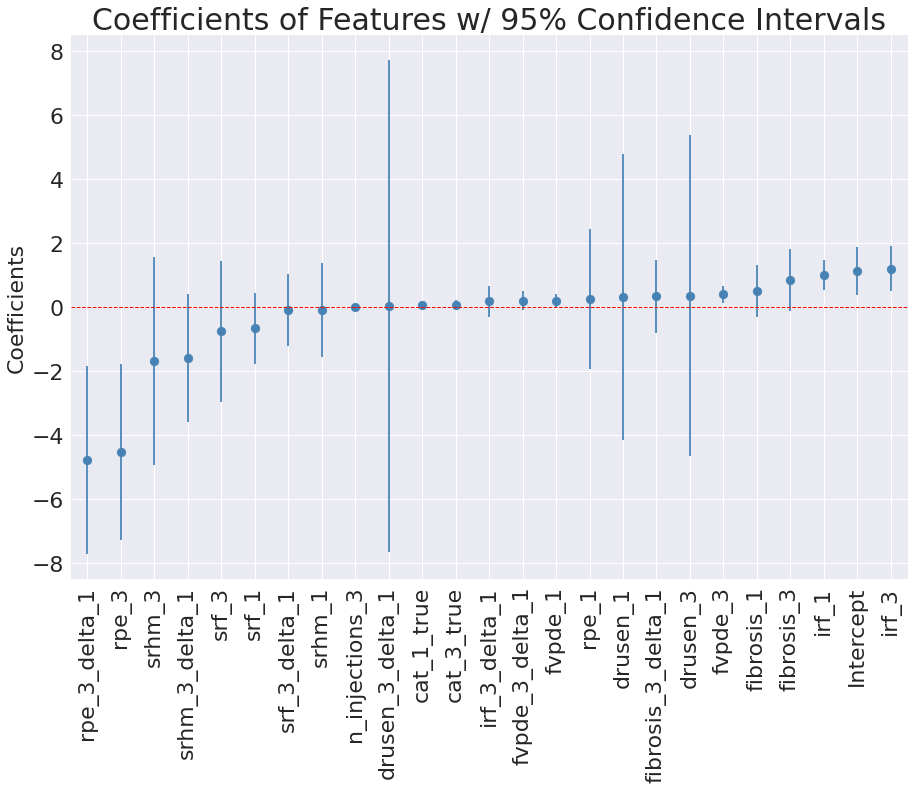

In [118]:
# Plot coefficients w/95% confidence intervals for Model
coefplot(result_lin)

In [119]:
regression_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     5.550
Date:                Tue, 01 Jun 2021   Prob (F-statistic):           5.45e-10
Time:                        14:34:30   Log-Likelihood:                -42.870
No. Observations:                 202   AIC:                             121.7
Df Residuals:                     184   BIC:                             181.3
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.1352      0.384      2.955      0.004       0.377       1.893
n_injections_3         0.0024      0.028      0.088      0.930      -0.052       0.057
irf_1                  1.0144      0.243      4.171      0.000       0.535       1.494
irf_3                  1.2093      0.359      3.371      0.001       0.502       1.917
irf_3_delta_1          0.1949      0.246      0.793      0.429      -0.290       0.680
srf_1                 -0.6595      0.569     -1.160      0.248      -1.781       0.462
srf_3                 -0.7476      1.117     -0.669      0.504      -2.951       1.456
srf_3_delta_1         -0.0881      0.571     -0.154      0.877      -1.214       1.038
srhm_1                -0.0803      0.743     -0.108      0.914      -1.547       1.386
srhm_3                -1.6656      1.649     -1.010      0.314      -4.919       1.588
srhm_3_delta_1        -1.5853      1.011     -1.568      0.119      -3.580       0.409
rpe_1                  0.2584      1.111      0.233      0.816      -1.934       2.451
rpe_3                 -4.5243      1.397     -3.238      0.001      -7.281      -1.767
rpe_3_delta_1         -4.7827      1.492     -3.206      0.002      -7.726      -1.839
fvpde_1                0.2050      0.109      1.887      0.061      -0.009       0.419
fvpde_3                0.4051      0.136      2.970      0.003       0.136       0.674
fvpde_3_delta_1        0.2002      0.149      1.344      0.181      -0.094       0.494
drusen_1               0.3295      2.263      0.146      0.884      -4.135       4.794
drusen_3               0.3611      2.542      0.142      0.887      -4.653       5.376
drusen_3_delta_1       0.0316      3.901      0.008      0.994      -7.665       7.728
fibrosis_1             0.5081      0.412      1.234      0.219      -0.304       1.320
fibrosis_3             0.8527      0.489      1.744      0.083      -0.112       1.817
fibrosis_3_delta_1     0.3445      0.578      0.596      0.552      -0.796       1.486
cat_1_true             0.0645      0.071      0.913      0.362      -0.075       0.204
cat_3_true             0.0847      0.071      1.190      0.236      -0.056       0.225
==============================================================================
Omnibus:                        7.697   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                7.581
Skew:                           0.432   Prob(JB):                       0.0226
Kurtosis:                       2.608   Cond. No.                     1.84e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.04e-34. This might indicate that there a

In [88]:
from statsmodels.tools.eval_measures import meanabs

X = df_regression[indep_vars]
y = df_regression["y"]

# now generate predictions
ypred = result_lin.predict(X)

# calc rmse
mae = meanabs(y, ypred)

mae_mean_predictor = meanabs(y, [y.mean()]*y.shape[0])

print("model mae is: ", mae, "mean predictor mae is: ", mae_mean_predictor)

model mae is:  0.24861686521160878 mean predictor mae is:  0.29931413888539


# Lasso

In [89]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import r2_score

independent_variables = indep_vars
outcome = "va_change"

df_regression = df_regression# [np.abs(abt_viz_norm.va_change) >= 0.15]

lasso = Lasso(alpha=0.0001, normalize=True).fit(df_regression[independent_variables], df_regression["y"])

importance = np.abs(lasso.coef_)
feature_names = np.array(independent_variables)

threshold = 0.00
feature_importance = {}
for k, imp in enumerate(importance):
    if imp > threshold:
        feature_importance[feature_names[k]] = (np.round(imp, 2), np.sign(lasso.coef_[k]))
        
print("Number of features selected by Lasso", len(feature_importance))


Number of features selected by Lasso 15


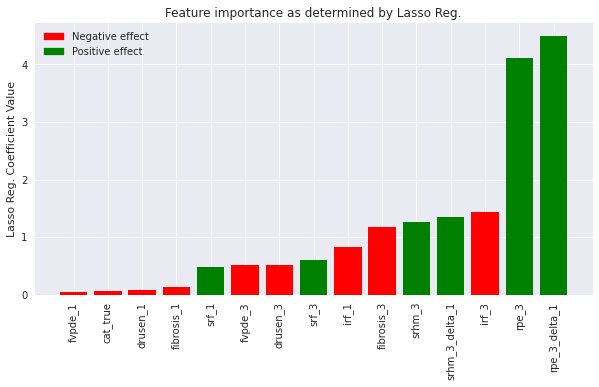

In [90]:
top = 20
feature_importance_sorted = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1][0])}

x = list(feature_importance_sorted.keys())[-top:]
heights = [value[0] for value in feature_importance_sorted.values()][-top:]

color_dict = {-1.0:"green", 1.0:"red"}
colors = [color_dict[value[1]] for value in feature_importance_sorted.values()][-top:]

plt.figure(figsize=(10,5))
plt.bar(x, height=heights, color=colors)
plt.xticks(rotation=90)
plt.ylabel("Lasso Reg. Coefficient Value")
plt.title("Feature importance as determined by Lasso Reg.")

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='red', label='Negative effect')
green_patch = mpatches.Patch(color='green', label='Positive effect')

plt.legend(handles=[red_patch, green_patch])
plt.show()

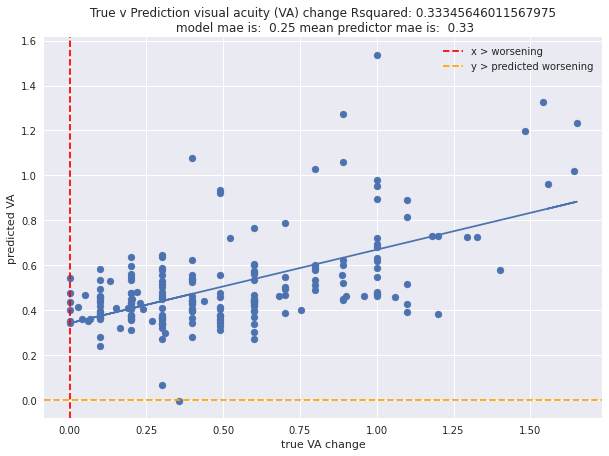

In [91]:
fig = plt.figure(figsize=(10,7))

predictions = lasso.predict(df_regression[independent_variables])
mae = np.mean(np.abs(predictions - df_regression["y"]))

plt.scatter(df_regression["y"], predictions)

m, b = np.polyfit(df_regression["y"], predictions, 1)

plt.plot(df_regression["y"], m*df_regression["y"] + b)

plt.axvline(x=0.0, linestyle="--", color="red", label="x > worsening")
plt.axhline(y=0.0, linestyle="--", color="orange", label="y > predicted worsening")

str1 = f"True v Prediction visual acuity (VA) change Rsquared: {r2_score(df_regression['y'], predictions)}"
str2 = f"\n model mae is:  {np.round(mae, 2)} mean predictor mae is:  0.33"
plt.title(str1 + str2)
plt.xlabel("true VA change")
          
plt.ylabel("predicted VA")
plt.legend()

# Visualize Time series

In [ ]:
def extract_viz_dict(case_patient, case_laterality, data_table):
    
    export_2_pat_filter = data_table.patient_id == case_patient
    export_2_study_laterality_filter = data_table.laterality == case_laterality

    export_2_filter = export_2_pat_filter & export_2_study_laterality_filter
    
    assert np.sum(export_2_filter), "sequence not present in data set, select other patient and eye"
    sequence_records = data_table[export_2_filter]

    # format date strings
    sequence_records.study_date_1 = sequence_records.study_date_1.str.replace("-", "")
    sequence_records.study_date_3 = sequence_records.study_date_3.str.replace("-", "")
    sequence_records.study_date_12 = sequence_records.study_date_12.str.replace("-", "")
    
    date_columns = ["study_date_1", "study_date_3", "study_date_12"]

    dates = [sequence_records[f"{date}"].iloc[0] for date in date_columns]

    viz_dict = {}

    times = [1, 3, 12]
    for k, date in enumerate(dates):
        seg_str = f"{sequence_records.sequence.iloc[0]}_{sequence_records[f'study_date_{times[k]}'].iloc[0]}"
        
        if not np.isnan(sequence_records[f"cataract_surgery_{times[k]}"].iloc[0]):
            surgery = sequence_records[f"cataract_surgery_{times[k]}"].iloc[0]
        else:
            surgery = 0
            
        viz_dict[date] = {"dicom_path": sequence_records[f"study_date_{times[k]}_dicom_path"].iloc[0], 
                          "seg_path": seg_str,
                          "cur_va_round": sequence_records[f"cur_va_rounded_{times[k]}"].iloc[0],
                          "injections": sequence_records[f"cumsum_injections_{times[k]}"].iloc[0],
                          "surgery": surgery,
                          "fv_ped": sequence_records[f"fibrovascular_ped_{times[k]}"].iloc[0],
                          "drusen": sequence_records[f"drusen_{times[k]}"].iloc[0],
                          "irf": sequence_records[f"intra_retinal_fluid_{times[k]}"].iloc[0],
                          "srf": sequence_records[f"sub_retinal_fluid_{times[k]}"].iloc[0],
                          "fibrosis": sequence_records[f"fibrosis_{times[k]}"].iloc[0],
                          "srhm": sequence_records[f"srhm_{times[k]}"].iloc[0],
                          "C0_thicknessmean": sequence_records[f"C0_thicknessmean_{times[k]}"].iloc[0],
                          "atropy_percentage": sequence_records[f"atropypercentage_{times[k]}"].iloc[0]}
        
    
    return viz_dict

def add_image_data_to_dict(viz_dict):
    for date in viz_dict.keys():
        date_dict = viz_dict[date]

        segmentation = np.load(os.path.join(SEG_E2_PATH, date_dict["seg_path"]+".npy"))
        
        # set sereous PED to Fib. Vasc. PED
        segmentation[segmentation == 11] = 7
        
        oct_slice = read_file(date_dict["dicom_path"]).pixel_array

        viz_dict[date]["segmentation"] = segmentation
        viz_dict[date]["oct"] = 255 - oct_slice

    return viz_dict


def add_data_panel(f, grid_spec, viz_dict, title="Best Corrected Visual Acuity (BCVA) over 12 month"):
    f_ax = f.add_subplot(grid_spec)

    f_ax2 = f_ax.twinx()

    y_min = 0
    y_max = 2.5

    injections = [int(viz_dict[date]["injections"]) for date in viz_dict.keys()]
    surgeries = [int(viz_dict[date]["surgery"]) for date in viz_dict.keys()]

    dates = [date for date in viz_dict.keys()]
    va_cuities = [np.round(viz_dict[date]["cur_va_round"], 2) for date in viz_dict.keys()]

    features = ["fv_ped", "drusen", "irf", "srf", "fibrosis", "srhm"]
    for feature in features:
        feate_values = [np.round(viz_dict[date][feature]*PIXEL_TO_VOLUME, 2) for date in viz_dict.keys()]
        f_ax2.plot([1, 4, 12], feate_values, "o-", label=feature)
        f_ax2.grid(False)

    f_ax2.legend(bbox_to_anchor=(1.2, 0.7))
    f_ax2.set_ylabel("Cubic mm")

    f_ax.bar([1, 4, 12], va_cuities)


    f_ax.set_ylim(y_min, y_max)
    f_ax.set_xlim(0, 13)

    line_height_1 = 1 / (y_max / viz_dict[dates[0]]["cur_va_round"]) + 0.1
    f_ax.text(x=1, y=y_max*line_height_1, s=f"  ({surgeries[0]})", fontdict=None, weight="bold")


    line_height_3 = 1 / (y_max / viz_dict[dates[1]]["cur_va_round"]) + 0.1
    f_ax.axvline(x=4, ymax=line_height_3, ymin=y_min, linestyle ="--", color="black")
    f_ax.text(x=4 + 0.2, y=y_max*line_height_3, s=injections[1], fontdict=None, weight="bold")
    f_ax.text(x=4 + 0.4, y=y_max*line_height_3, s=f"({surgeries[1]})", fontdict=None, weight="bold")

    # set month 12 injection data 
    line_height_12 = 1 / (y_max / viz_dict[dates[2]]["cur_va_round"]) + 0.1
    f_ax.axvline(x=12, ymax=line_height_12, ymin=y_min, linestyle ="--", color="black")
    f_ax.text(x=12 + 0.2, y=y_max*line_height_12, s=injections[2], fontdict=None, weight="bold")
    f_ax.text(x=12 + 0.5, y=y_max*line_height_12, s=f"({surgeries[2]})", fontdict=None, weight="bold")

    # plot injection legend
    f_ax.axhline(y=y_max*0.95, xmin=0.75, xmax=0.82, linestyle ="--", color="black")
    f_ax.text(x=10.5 + 0.2, y=y_max*0.95, s="injections", fontdict=None, weight="bold")
    f_ax.text(x=10.5, y=y_max*0.87, s="(.) surgery", fontdict=None, weight="bold")

    f_ax.set_xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12])
    f_ax.set_xticklabels(labels=["0","","","3","","","","","","","","12"])
    f_ax.set_xlabel('month')
    f_ax.set_ylabel('best corrected visual acuity (BCVA)')
    f_ax.set_title(title)

    f_ax.grid(True)
    
    
def add_oct_panel(f, grid_spec, viz_dict, date, title=""):
    f_ax = f.add_subplot(grid_spec)
    
    oct1 = viz_dict[date]["oct"][5,:,:]
    oct2 = viz_dict[date]["oct"][7,:,:]
    oct3 = viz_dict[date]["oct"][10,:,:]
    oct4 = viz_dict[date]["oct"][13,:,:]
    oct5 = viz_dict[date]["oct"][15,:,:]
    oct6 = viz_dict[date]["oct"][18,:,:]
    oct7 = viz_dict[date]["oct"][20,:,:]
    oct8 = viz_dict[date]["oct"][23,:,:]
    oct9 = viz_dict[date]["oct"][25,:,:]
    oct10 = viz_dict[date]["oct"][28,:,:]
    oct11 = viz_dict[date]["oct"][30,:,:]
    oct12 = viz_dict[date]["oct"][33,:,:]
    oct13 = viz_dict[date]["oct"][35,:,:]
    oct14 = viz_dict[date]["oct"][40,:,:]
    oct15 = viz_dict[date]["oct"][45,:,:]
    
    oct_u = np.concatenate([oct1, oct2, oct3, oct4, oct5], axis=1)
    oct_m = np.concatenate([oct6, oct7, oct8, oct9, oct10], axis=1)
    oct_l = np.concatenate([oct11, oct12, oct13, oct14, oct15], axis=1)
    
    oct_ = np.concatenate([oct_u, oct_m, oct_l], axis=0)
    
    f_ax.imshow(oct_)
    f_ax.axis("off")
    
    
def add_segmentation_panel(f, grid_spec, viz_dict, date, title=""):
    custom_cmap, norm, bounds = plotting.color_mappings()
    
    oct1 = viz_dict[date]["segmentation"][5,:,:]
    oct2 = viz_dict[date]["segmentation"][7,:,:]
    oct3 = viz_dict[date]["segmentation"][10,:,:]
    oct4 = viz_dict[date]["segmentation"][13,:,:]
    oct5 = viz_dict[date]["segmentation"][15,:,:]
    oct6 = viz_dict[date]["segmentation"][18,:,:]
    oct7 = viz_dict[date]["segmentation"][20,:,:]
    oct8 = viz_dict[date]["segmentation"][23,:,:]
    oct9 = viz_dict[date]["segmentation"][25,:,:]
    oct10 = viz_dict[date]["segmentation"][28,:,:]
    oct11 = viz_dict[date]["segmentation"][30,:,:]
    oct12 = viz_dict[date]["segmentation"][33,:,:]
    oct13 = viz_dict[date]["segmentation"][35,:,:]
    oct14 = viz_dict[date]["segmentation"][40,:,:]
    oct15 = viz_dict[date]["segmentation"][45,:,:]
    
    oct_u = np.concatenate([oct1, oct2, oct3, oct4, oct5], axis=1)
    oct_m = np.concatenate([oct6, oct7, oct8, oct9, oct10], axis=1)
    oct_l = np.concatenate([oct11, oct12, oct13, oct14, oct15], axis=1)
    
    oct_ = np.concatenate([oct_u, oct_m, oct_l], axis=0)

    f_ax = f.add_subplot(grid_spec)
    f_ax.imshow(oct_, interpolation='nearest', cmap=custom_cmap, norm=norm)
    f_ax.set_title(title)

    f_ax.axis("off")
    

def add_image_panels(viz_dict, gs):
    iter_ = 0
    col_panels = [0,1,2]
    col_panels_month = {0: "0", 1:"3", 2:"12"}
    for date in [date for date in viz_dict.keys()]:
        add_oct_panel(f, gs[-1,col_panels[iter_]], viz_dict, date, title="")
        
        month = col_panels_month[col_panels[iter_]]
        
        add_segmentation_panel(f, gs[-2,col_panels[iter_]], viz_dict, date, 
                               title=f'month {month}. BCVA: {np.round(viz_dict[date]["cur_va_round"], 2)}')
        iter_ += 1


def add_va_panel(f, grid_spec, viz_dict, title="Best Corrected Visual Acuity (BCVA) over 12 month"):
    f_ax = f.add_subplot(grid_spec)

    y_min = 0
    y_max = 2.5

    injections = [int(viz_dict[date]["injections"]) for date in viz_dict.keys()]
    surgeries = [int(viz_dict[date]["surgery"]) for date in viz_dict.keys()]

    dates = [date for date in viz_dict.keys()]
    va_cuities = [np.round(viz_dict[date]["cur_va_round"], 2) for date in viz_dict.keys()]

    f_ax.bar([1, 4, 12], va_cuities)

    f_ax.set_ylim(y_min, y_max)
    f_ax.set_xlim(0, 13)

    line_height_1 = 1 / (y_max / viz_dict[dates[0]]["cur_va_round"]) + 0.1
    f_ax.text(x=1, y=y_max*line_height_1, s=f"  ({surgeries[0]})", fontdict=None, weight="bold")


    line_height_3 = 1 / (y_max / viz_dict[dates[1]]["cur_va_round"]) + 0.1
    f_ax.axvline(x=4, ymax=line_height_3, ymin=y_min, linestyle ="--", color="black")
    f_ax.text(x=4 + 0.2, y=y_max*line_height_3, s=injections[1], fontdict=None, weight="bold")
    f_ax.text(x=4 + 0.4, y=y_max*line_height_3, s=f"({surgeries[1]})", fontdict=None, weight="bold")

    # set month 12 injection data 
    line_height_12 = 1 / (y_max / viz_dict[dates[2]]["cur_va_round"]) + 0.1
    f_ax.axvline(x=12, ymax=line_height_12, ymin=y_min, linestyle ="--", color="black")
    f_ax.text(x=12 + 0.2, y=y_max*line_height_12, s=injections[2], fontdict=None, weight="bold")
    f_ax.text(x=12 + 0.5, y=y_max*line_height_12, s=f"({surgeries[2]})", fontdict=None, weight="bold")

    # plot injection legend
    f_ax.axhline(y=y_max*0.95, xmin=0.75, xmax=0.82, linestyle ="--", color="black")
    f_ax.text(x=10.5 + 0.2, y=y_max*0.95, s="injections", fontdict=None, weight="bold")
    f_ax.text(x=10.5, y=y_max*0.87, s="(.) surgery", fontdict=None, weight="bold")

    f_ax.set_xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12])
    f_ax.set_xticklabels(labels=["0","","","3","","","","","","","","12"])
    f_ax.set_xlabel('month')
    f_ax.set_ylabel('best corrected visual acuity (BCVA)')
    f_ax.set_title(title)

    f_ax.grid(True)
                               
def add_feature_multi_panels(f, grid_spec, viz_dict, features1, features2):
                               
                               
    title="Features over time"
                               
    f_ax = f.add_subplot(grid_spec)

    f_ax2 = f_ax.twinx()

    dates = [date for date in viz_dict.keys()]
    
    for feature in features2:
        if feature == "C0_thicknessmean":
            feate_values = [np.round(viz_dict[date][feature], 2) for date in viz_dict.keys()]
        else:
            feate_values = [np.round(viz_dict[date][feature]*PIXEL_TO_VOLUME, 2) for date in viz_dict.keys()]        
        
        f_ax2.plot([1, 4, 12], feate_values, "o-", label=feature)
                               
    for feature in features1:
        if feature == "C0_thicknessmean":
            feate_values = [np.round(viz_dict[date][feature], 2) for date in viz_dict.keys()]
        else:
            feate_values = [np.round(viz_dict[date][feature]*PIXEL_TO_VOLUME, 2) for date in viz_dict.keys()]
        
        f_ax.plot([1, 4, 12], feate_values, "--", label=feature)

    f_ax.grid(False)
    
    f_ax.legend(loc="upper left")
    f_ax.set_ylabel(f"Cubic mm, {'-'.join(features2)}")
    f_ax2.grid(False)
                               
    f_ax2.legend(loc="lower left")
    f_ax2.set_ylabel(f"Cubic mm, {'-'.join(features1)}")
                               
    f_ax.set_xlim(0, 13)

    f_ax.set_xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12])
    f_ax.set_xticklabels(labels=["0","","","3","","","","","","","","12"])
    f_ax.set_xlabel('month')
    f_ax.set_title(title)
    f_ax.grid(True)
    

### Reset index of abt plt for joinining

In [ ]:
feature_columns = ["fibrovascular_ped", "drusen", "intra_retinal_fluid", "sub_retinal_fluid", 
                   "fibrosis", "srhm"]
time_points = [1, 3, 12]

feature_ranges = {}
for feature in feature_columns:
    feature_ranges[feature] = {}
    
    min_values = []
    max_values = []
    mean_values = []
    for time_ in time_points:
        min_values.append(min(viz_pd[f"{feature}_{time_}"]))
        max_values.append(max(viz_pd[f"{feature}_{time_}"]))
        mean_values.append(np.mean(viz_pd[f"{feature}_{time_}"]))
               
    feature_ranges[feature]["max"] = max(max_values)
    feature_ranges[feature]["min"] = min(min_values)
    feature_ranges[feature]["mean"] = np.mean(mean_values)

In [ ]:
import random

# copy data frame from main & merge with ts characterizations
viz_pd = data_pd[filter_1&filter_3&filter_12].copy()

# drop not used columns
viz_pd = viz_pd.drop(columns=["Unnamed: 0"])

# add select columns
viz_pd["case_select_columns"] = None

viz_pd = viz_pd.rename(columns={"cataract_surgery_before_sequence": "cataract_surgery_1"})

for sequence in viz_pd.sequence.values:
    # try:
    # get segmentation volume path
    case_patient, case_laterality = sequence.split("_")

    # set case manually
    case_patient = "60769"
    case_laterality = "R"

    print("Plotting sequence: ", case_patient, case_laterality)

    viz_dict = extract_viz_dict(case_patient=case_patient, case_laterality=case_laterality, data_table=viz_pd)
    viz_dict = add_image_data_to_dict(viz_dict)

    # plot example
    plt.style.use('seaborn-whitegrid')
    f = plt.figure(constrained_layout=True, figsize=(30,15))
    gs = f.add_gridspec(3, 3)

    add_va_panel(f, gs[0,0], viz_dict, title="Best Corrected Visual Acuity (BCVA) over 12 month")
    add_feature_multi_panels(f, gs[0, 1], viz_dict, 
                       ["fv_ped", "fibrosis"], 
                       ["drusen", "srf"])


    add_feature_multi_panels(f, gs[0, 2], viz_dict, 
                       ["irf"], 
                       ["C0_thicknessmean"])

    add_image_panels(viz_dict, gs)
    f.suptitle(f"Patient: {case_patient}, Eye: {case_laterality}")

    if not os.path.exists(os.path.join(WORK_SPACE, "longitudinal_plots")):
        os.makedirs(os.path.join(WORK_SPACE, "longitudinal_plots"))

    plt.savefig(os.path.join(WORK_SPACE, "longitudinal_plots", 
                             f"Patient-{case_patient}-Eye-{case_laterality}.png"))

    plt.close()
    #except Exception:
    #    print("Record not working: ", sequence)
    #    continue
        
    break

In [ ]:
viz_dict